In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install neo #Install neo so we can load the dataset since its not a numpy data type

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.1/655.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 10.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.decomposition import PCA
from neo.io import NeuralynxIO
import neo
import h5py
import random
import os

In [5]:
data = neo.io.NeuralynxIO(dirname="/content/drive/MyDrive/UCLA_data/") #We load the directory of dataset
seg = data.read_segment() #We read the data and metadata of dataset
dataset = seg.analogsignals[0].magnitude #Now we access the file's analog signal and then get the sampling rate
sampling_rate = seg.analogsignals[0].sampling_rate.item()

In [6]:
print(sampling_rate) #Just trying to check the sampling rate that was accessed from the dataset

32051.0


In [7]:
#Here we use the scipy butterworth and filtfilt to filter the signals and also select the frequency range
def bandpass_filter(dataset, lowcut, highcut, sampling_rate, order=4): #4th order should give a stable steepness in sharp waveform edge
  nyquist = 0.5 * sampling_rate
  low = lowcut / nyquist
  high = highcut / nyquist
  b, a = butter(order, [low, high], btype='band')
  filtered_data = filtfilt(b, a, dataset, axis=0)
  return filtered_data

filtered_signal = bandpass_filter(dataset, 300, 3000, sampling_rate) #I found the range from the MATLAB .mat file

In [8]:
print(filtered_signal) #Just trying to check the filtered signal
np.save('/content/drive/MyDrive/UCLA_data/filtered_signal.npy', filtered_signal) #Saving filtered signal for post-cluster analysis

[[-0.83945686]
 [ 0.43668145]
 [ 1.70229882]
 ...
 [-4.29864826]
 [-2.8643729 ]
 [-1.11818646]]


In [ ]:
#Now we define the threshold using the pattern quiroga defined in his paper with multiple of standard deviation
threshold = 5 * np.std(filtered_signal) #After checking the MATLAB .mat file, I applied the multiple of 5 while a max is 50.
spike_indices = np.where(filtered_signal > threshold)[0]

In [ ]:
print(spike_indices) #Just inspecting the index(indices) where spikes are detected in the recorded data

[   16480    16481    16482 ... 60961863 60961864 60961865]


In [ ]:
#Extracting the waveforms using the indices
spike_waveforms = []
window_size = int(0.001 * sampling_rate) #Here we create the window size using 1ms calculation with 32051 Hz
for idx in spike_indices:
  if idx > window_size and idx < len(filtered_signal) - window_size:
    spike_waveforms.append(filtered_signal[idx - window_size:idx + window_size])
spike_waveforms = np.array(spike_waveforms)

# Separate negative and positive spikes in Python pipeline so we can compare with combinato results
negative_spike_indices = np.where(filtered_signal[spike_indices] < 0)[0]
positive_spike_indices = np.where(filtered_signal[spike_indices] >= 0)[0]

negative_spikes = spike_waveforms[negative_spike_indices]
positive_spikes = spike_waveforms[positive_spike_indices]

In [ ]:
print(negative_spikes) #Just trying to check the negative spikes
print(positive_spikes) #Just trying to check the positive spikes

[]
[[[-14.95179509]
  [-15.21445329]
  [-15.27037967]
  ...
  [-28.91402589]
  [-27.98137029]
  [-27.98147366]]

 [[-15.21445329]
  [-15.27037967]
  [-15.22513445]
  ...
  [-27.98137029]
  [-27.98147366]
  [-28.65222882]]

 [[-15.27037967]
  [-15.22513445]
  [-15.10194672]
  ...
  [-27.98147366]
  [-28.65222882]
  [-29.46870021]]

 ...

 [[ -4.65800429]
  [ -5.41154265]
  [ -6.02983692]
  ...
  [ -8.23811741]
  [ -9.06908794]
  [-10.31524649]]

 [[ -5.41154265]
  [ -6.02983692]
  [ -6.38578365]
  ...
  [ -9.06908794]
  [-10.31524649]
  [-11.73086752]]

 [[ -6.02983692]
  [ -6.38578365]
  [ -6.49309996]
  ...
  [-10.31524649]
  [-11.73086752]
  [-13.01290297]]]


In [ ]:
print(spike_waveforms) #Just trying to check the spike waveforms

[[[-14.95179509]
  [-15.21445329]
  [-15.27037967]
  ...
  [-28.91402589]
  [-27.98137029]
  [-27.98147366]]

 [[-15.21445329]
  [-15.27037967]
  [-15.22513445]
  ...
  [-27.98137029]
  [-27.98147366]
  [-28.65222882]]

 [[-15.27037967]
  [-15.22513445]
  [-15.10194672]
  ...
  [-27.98147366]
  [-28.65222882]
  [-29.46870021]]

 ...

 [[ -4.65800429]
  [ -5.41154265]
  [ -6.02983692]
  ...
  [ -8.23811741]
  [ -9.06908794]
  [-10.31524649]]

 [[ -5.41154265]
  [ -6.02983692]
  [ -6.38578365]
  ...
  [ -9.06908794]
  [-10.31524649]
  [-11.73086752]]

 [[ -6.02983692]
  [ -6.38578365]
  [ -6.49309996]
  ...
  [-10.31524649]
  [-11.73086752]
  [-13.01290297]]]


In [ ]:
#Seems the PCA expects a 2d array instead of 3, so we rehape the spike_waveforms to a 2d array
spike_waveforms_reshaped = spike_waveforms.reshape(spike_waveforms.shape[0], -1) #We use -1 to remove one dimension

In [ ]:
print(spike_waveforms_reshaped) #Just trying to check the 2D reshaped spike waveforms

[[-14.95179509 -15.21445329 -15.27037967 ... -28.91402589 -27.98137029
  -27.98147366]
 [-15.21445329 -15.27037967 -15.22513445 ... -27.98137029 -27.98147366
  -28.65222882]
 [-15.27037967 -15.22513445 -15.10194672 ... -27.98147366 -28.65222882
  -29.46870021]
 ...
 [ -4.65800429  -5.41154265  -6.02983692 ...  -8.23811741  -9.06908794
  -10.31524649]
 [ -5.41154265  -6.02983692  -6.38578365 ...  -9.06908794 -10.31524649
  -11.73086752]
 [ -6.02983692  -6.38578365  -6.49309996 ... -10.31524649 -11.73086752
  -13.01290297]]


In [ ]:
#Final step of preprocessing would be to extract the features of the signals using PCA (we will use wavelet in combinato automatic preprocessing)
pca_extraction = PCA(n_components=3)
pca_features = pca_extraction.fit_transform(spike_waveforms_reshaped)

In [ ]:
print(pca_features) #Just trying to check the PCA extraction

[[-178.55805001   62.51891299    1.7762095 ]
 [-159.75025434   81.74703753  -26.72954032]
 [-133.01438636   96.71383602  -49.61821836]
 ...
 [ -19.90567886  -79.83674235   -3.03135459]
 [  -5.14840475  -80.39137024    0.78172603]
 [   9.19240137  -82.3065842     5.68181075]]


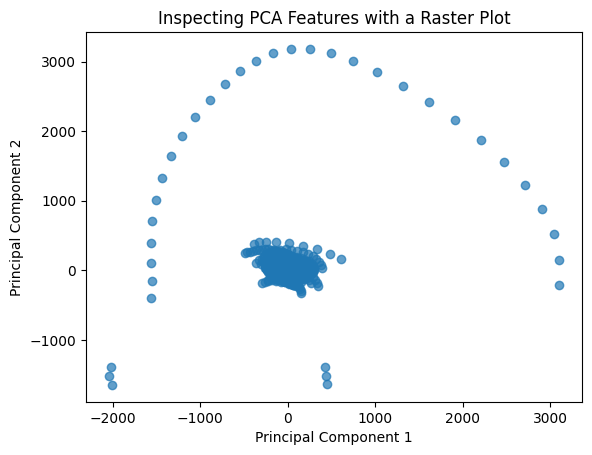

In [ ]:
#Visualizing the PCA results in a raster plot
plt.scatter(pca_features[:, 0], pca_features[:, 1], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Inspecting PCA Features with a Raster Plot')
plt.show()

## Here we compare the results from our Manual Preprocessing with Python Pipeline and the Automatic Preprocessing with Combinato

In [ ]:
# To inspect the elements in the combinato .h5 file
file_path = "/content/drive/MyDrive/UCLA_data/combinato_CSC4.h5"
combinato_file = h5py.File(file_path, "r")

# List the datasets in the file
print("Datasets in the file:")
for key in combinato_file.keys():
    print(key)

Datasets in the file:
neg
pos
thr


In [ ]:
# Before we can access the results within the .h5 file, we inspect and recursively print the structure of the file
def print_structure(group, indent=0):
    for key in group:
        print(" " * indent + f"{key}: {type(group[key])}")
        if isinstance(group[key], h5py.Group):  # If it's a group, recurse
            print_structure(group[key], indent + 2)

print("File Structure:")
print_structure(combinato_file)

File Structure:
neg: <class 'h5py._hl.group.Group'>
  artifacts: <class 'h5py._hl.dataset.Dataset'>
  spikes: <class 'h5py._hl.dataset.Dataset'>
  times: <class 'h5py._hl.dataset.Dataset'>
pos: <class 'h5py._hl.group.Group'>
  artifacts: <class 'h5py._hl.dataset.Dataset'>
  spikes: <class 'h5py._hl.dataset.Dataset'>
  times: <class 'h5py._hl.dataset.Dataset'>
thr: <class 'h5py._hl.dataset.Dataset'>


In [ ]:
# Now we access the datasets within the groups
neg_artifacts = combinato_file['neg']['artifacts'][:]
neg_spikes = combinato_file['neg']['spikes'][:]
neg_times = combinato_file['neg']['times'][:]

pos_artifacts = combinato_file['pos']['artifacts'][:]
pos_spikes = combinato_file['pos']['spikes'][:]
pos_times = combinato_file['pos']['times'][:]

threshold = combinato_file['thr'][:]

# Print basic info about the datasets
print(f"Negative Spikes Shape: {neg_spikes.shape}")
print(f"Positive Spikes Shape: {pos_spikes.shape}")
print(f"Negative Artifacts Shape: {neg_artifacts.shape}")
print(f"Positive Artifacts Shape: {pos_artifacts.shape}")
print(f"Negative Spike Times Shape: {neg_times.shape}")
print(f"Positive Spike Times Shape: {pos_times.shape}")
print(f"Threshold: {threshold}")

Negative Spikes Shape: (1917, 64)
Positive Spikes Shape: (12719, 64)
Negative Artifacts Shape: (1917,)
Positive Artifacts Shape: (12719,)
Negative Spike Times Shape: (1917,)
Positive Spike Times Shape: (12719,)
Threshold: [[1.24797727e+05 2.83517696e+05 2.15315442e+01]
 [2.83517727e+05 4.42237696e+05 2.12061095e+01]
 [4.42237727e+05 6.00957696e+05 2.13638431e+01]
 [6.00957727e+05 7.59677696e+05 2.10928245e+01]
 [7.59677727e+05 9.18397696e+05 2.12003510e+01]
 [9.18397727e+05 1.07711770e+06 2.11385007e+01]
 [1.07711773e+06 1.23583770e+06 2.12264151e+01]
 [1.23583773e+06 1.39455770e+06 2.12495975e+01]
 [1.39455773e+06 1.55327770e+06 2.12752577e+01]
 [1.55327773e+06 1.71199770e+06 2.12676013e+01]
 [1.71199773e+06 2.01580365e+06 2.10486448e+01]]


In [ ]:
# Compute mean and variance for combinato spikes
neg_mean = np.mean(neg_spikes, axis=0)
neg_var = np.var(neg_spikes, axis=0)
pos_mean = np.mean(pos_spikes, axis=0)
pos_var = np.var(pos_spikes, axis=0)

print("Combinato Negative Spikes - Mean:", neg_mean, "Variance:", neg_var)
print("Combinato Positive Spikes - Mean:", pos_mean, "Variance:", pos_var)

Combinato Negative Spikes - Mean: [ 18.166912    14.361402    10.883714     7.6730146    4.6642694
   1.7659518   -1.126069    -4.059656    -6.9728823   -9.717372
 -12.135491   -14.132972   -15.726948   -17.08516    -18.538673
 -20.483957   -23.117607   -26.125854   -28.635702   -29.643883
 -28.698729   -26.251598   -23.33257    -20.85684    -19.165737
 -18.06816    -17.175646   -16.19177    -14.98935    -13.544823
 -11.89218    -10.140958    -8.468983    -7.0504885   -5.9871926
  -5.290906    -4.9021473   -4.7186794   -4.621698    -4.5066166
  -4.323186    -4.0920944   -3.8705378   -3.7012773   -3.5923994
  -3.5264285   -3.4760678   -3.4156966   -3.3225343   -3.173031
  -2.9499195   -2.656393    -2.3210454   -1.9931116   -1.7351409
  -1.606524    -1.6295395   -1.7550445   -1.8696615   -1.8603874
  -1.6881561   -1.4067183   -1.1185914   -0.90998197] Variance: [506.26736  419.11185  347.6148   293.75183  285.00073  328.89896
 345.00552  274.15027  178.44055  122.416725  99.8993    87.19

In [ ]:
# Compute same for the Python pipeline spikes
pipeline_mean = np.mean(spike_waveforms, axis=0)
pipeline_var = np.var(spike_waveforms, axis=0)

print("Python Pipeline Spikes - Mean:", pipeline_mean, "Variance:", pipeline_var)

Python Pipeline Spikes - Mean: [[-10.50107493]
 [-10.89528178]
 [-11.2883319 ]
 [-11.67948612]
 [-12.06394292]
 [-12.43365814]
 [-12.77968831]
 [-13.09550739]
 [-13.38023341]
 [-13.64040107]
 [-13.88896458]
 [-14.14068261]
 [-14.40388921]
 [-14.66973968]
 [-14.90108536]
 [-15.02387259]
 [-14.92408826]
 [-14.45259927]
 [-13.43875775]
 [-11.7116289 ]
 [ -9.12567269]
 [ -5.58636372]
 [ -1.0711484 ]
 [  4.35757704]
 [ 10.54869508]
 [ 17.26716045]
 [ 24.20594915]
 [ 31.00423324]
 [ 37.2718658 ]
 [ 42.6206716 ]
 [ 46.70198215]
 [ 49.24728782]
 [ 50.10572736]
 [ 49.2699615 ]
 [ 46.88231934]
 [ 43.21664906]
 [ 38.63731001]
 [ 33.54316296]
 [ 28.30879103]
 [ 23.23582996]
 [ 18.52405242]
 [ 14.26606128]
 [ 10.46318011]
 [  7.05532444]
 [  3.95546306]
 [  1.07993242]
 [ -1.63129427]
 [ -4.20643314]
 [ -6.64429245]
 [ -8.92342433]
 [-11.01353554]
 [-12.88543669]
 [-14.51740856]
 [-15.8975946 ]
 [-17.02333437]
 [-17.89895333]
 [-18.53343304]
 [-18.9388346 ]
 [-19.12966266]
 [-19.12283103]
 [-18.937

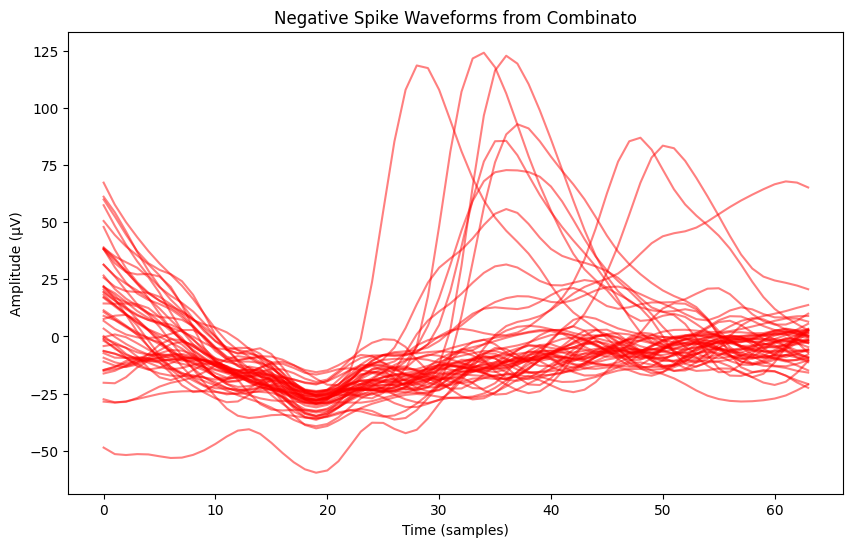

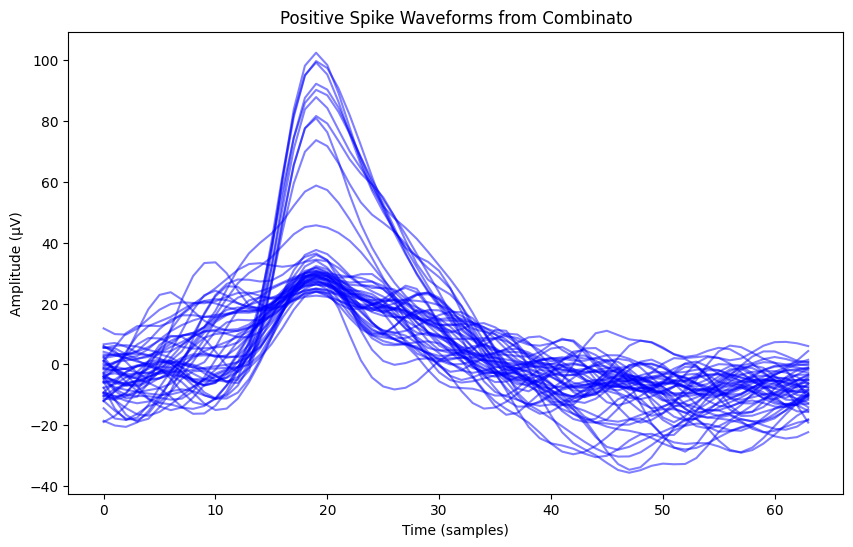

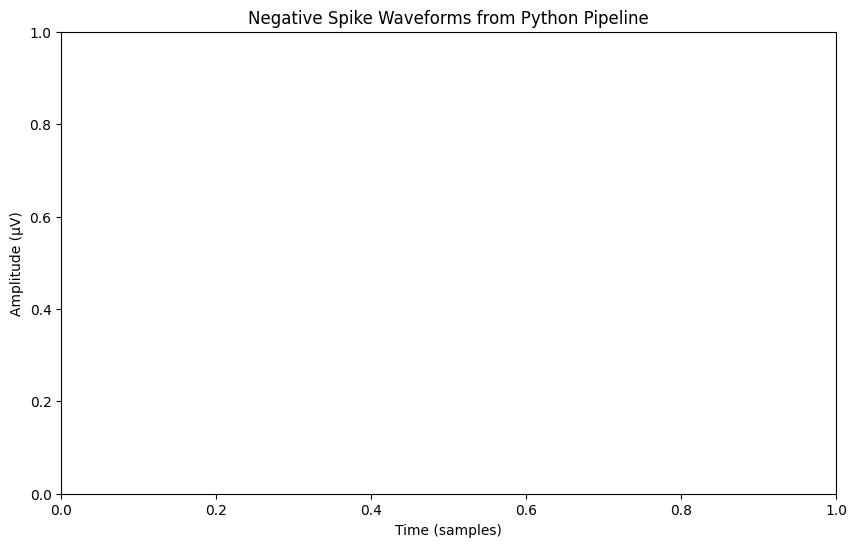

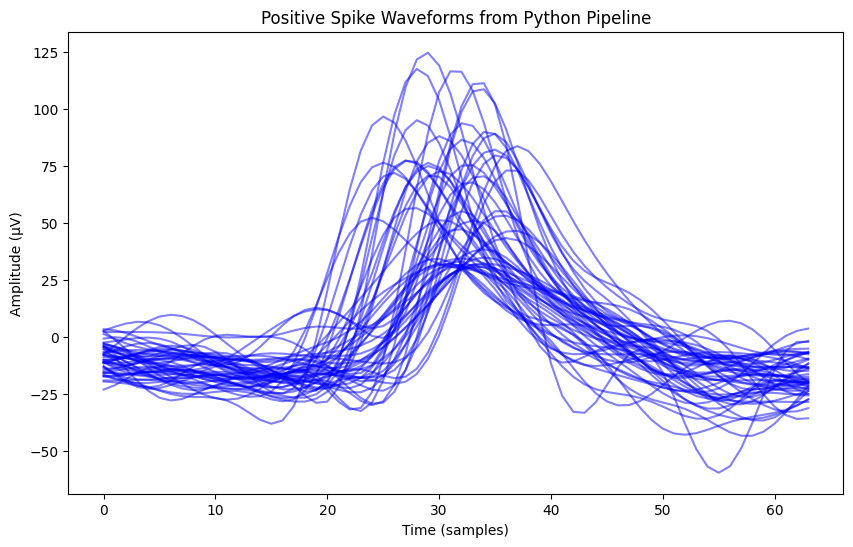

In [ ]:
# To visulaize the spikes, we select a random subset of spikes to plot for visualization due to high volume of data
num_samples = 50  # Number of waveforms to visualize

# Random indices for combinato negative and positive spikes
neg_random_indices = random.sample(range(neg_spikes.shape[0]), min(num_samples, neg_spikes.shape[0]))
pos_random_indices = random.sample(range(pos_spikes.shape[0]), min(num_samples, pos_spikes.shape[0]))

# Plot negative spikes from Combinato
plt.figure(figsize=(10, 6))
for i in neg_random_indices:
    plt.plot(neg_spikes[i], color='red', alpha=0.5)
plt.title("Negative Spike Waveforms from Combinato")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (μV)")
plt.show()

# Plot positive spikes from Combinato
plt.figure(figsize=(10, 6))
for i in pos_random_indices:
    plt.plot(pos_spikes[i], color='blue', alpha=0.5)
plt.title("Positive Spike Waveforms from Combinato")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (μV)")
plt.show()

# Random indices for python pipeline negative and positive spikes
negative_random_indices = random.sample(range(negative_spikes.shape[0]), min(num_samples, negative_spikes.shape[0]))
positive_random_indices = random.sample(range(positive_spikes.shape[0]), min(num_samples, positive_spikes.shape[0]))

# Plot negative spikes from Combinato
plt.figure(figsize=(10, 6))
for i in negative_random_indices:
    plt.plot(negative_spikes[i], color='red', alpha=0.5)
plt.title("Negative Spike Waveforms from Python Pipeline")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (μV)")
plt.show()

# Plot positive spikes from Combinato
plt.figure(figsize=(10, 6))
for i in positive_random_indices:
    plt.plot(positive_spikes[i], color='blue', alpha=0.5)
plt.title("Positive Spike Waveforms from Python Pipeline")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (μV)")
plt.show()

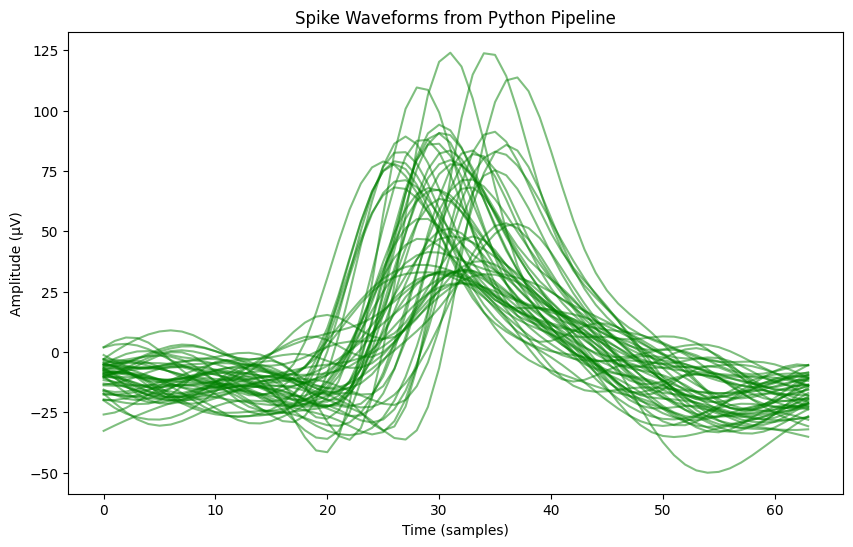

In [ ]:
# Plot random spike waveforms from Python pipeline
pipeline_random_indices = random.sample(range(spike_waveforms.shape[0]), min(num_samples, spike_waveforms.shape[0]))
plt.figure(figsize=(10, 6))
for i in pipeline_random_indices:
    plt.plot(spike_waveforms[i], color='green', alpha=0.5)
plt.title("Spike Waveforms from Python Pipeline")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (μV)")
plt.show()

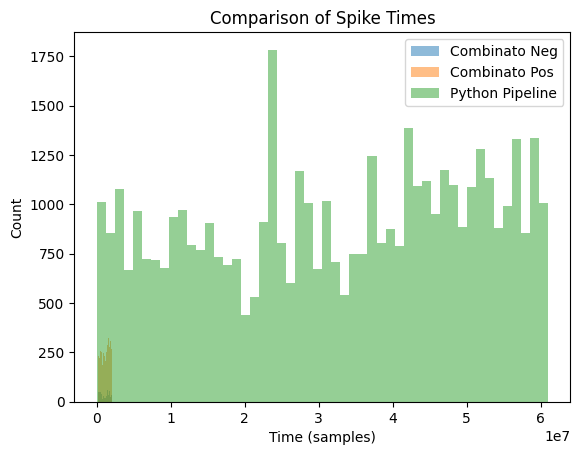

In [ ]:
# Visualizing the spike times with a histogram
plt.hist(neg_times, bins=50, alpha=0.5, label="Combinato Neg")
plt.hist(pos_times, bins=50, alpha=0.5, label="Combinato Pos")
plt.hist(spike_indices, bins=50, alpha=0.5, label="Python Pipeline")
plt.legend()
plt.title("Comparison of Spike Times")
plt.xlabel("Time (samples)")
plt.ylabel("Count")
plt.show()

In [ ]:
# Inspecting the difference in threshold between the two preprocessed results
print(f"Combinato Threshold: {threshold}")
print(f"Python Pipeline Threshold: {5 * np.std(filtered_signal)}")

Combinato Threshold: 28.322941120267036
Python Pipeline Threshold: 28.322941120267036


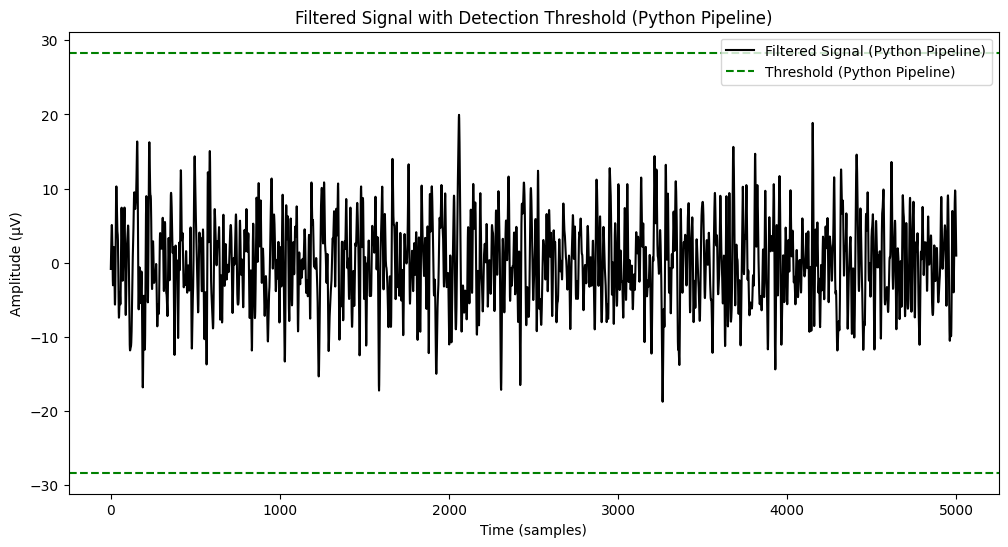

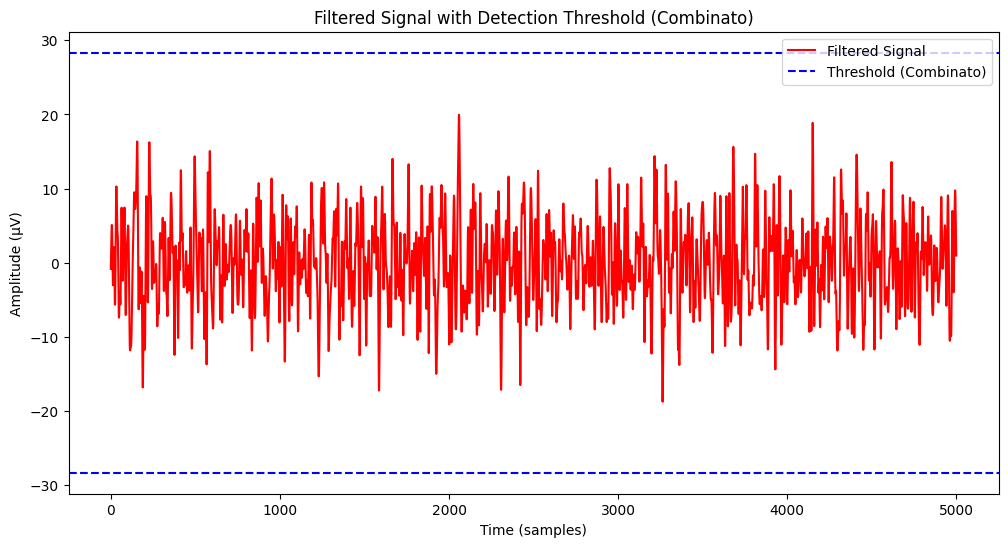

In [ ]:
# Plot filtered signal with Python pipeline threshold
plt.figure(figsize=(12, 6))
plt.plot(filtered_signal[:5000], color='black', label="Filtered Signal (Python Pipeline)")
plt.axhline(5 * np.std(filtered_signal), color='green', linestyle='--', label="Threshold (Python Pipeline)")
plt.axhline(-5 * np.std(filtered_signal), color='green', linestyle='--')
plt.title("Filtered Signal with Detection Threshold (Python Pipeline)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (μV)")
plt.legend()
plt.show()

# Plot a segment of the signal with Combinato thresholds
plt.figure(figsize=(12, 6))
plt.plot(filtered_signal[:5000], color='red', label="Combinato Filtered Signal")
plt.axhline(threshold, color='blue', linestyle='--', label="Threshold (Combinato)")
plt.axhline(-threshold, color='blue', linestyle='--')
plt.title("Filtered Signal with Detection Threshold (Combinato)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (μV)")
plt.legend()
plt.show()

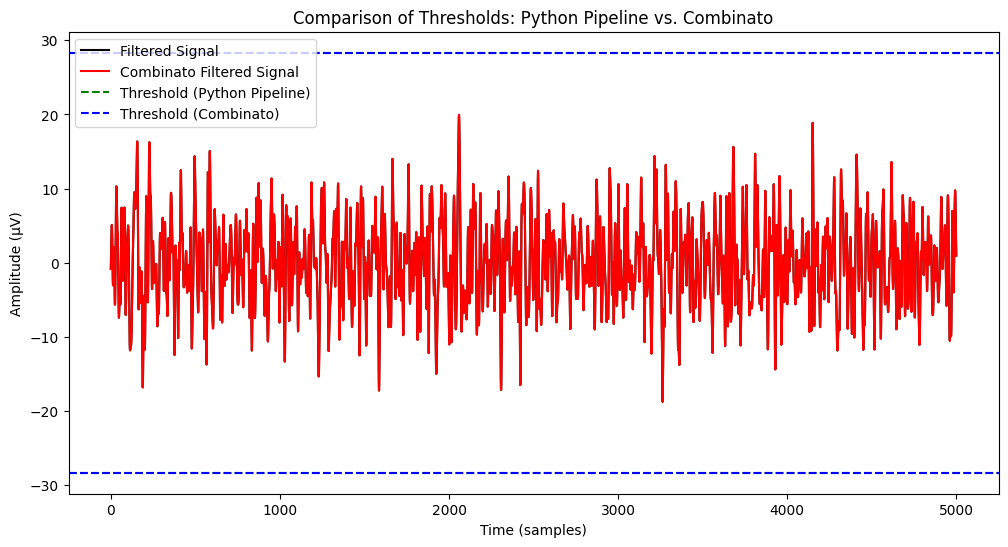

In [ ]:
# Visualizing filtered signal with thresholds from both combinato and python pipeline
plt.figure(figsize=(12, 6))

# Plotting a small segment of the filtered signal due to data volume ofcourse
plt.plot(filtered_signal[:5000], color='black', label="Filtered Signal")
plt.plot(filtered_signal[:5000], color='red', label="Combinato Filtered Signal")

# Overlaying the Python pipeline thresholds
plt.axhline(5 * np.std(filtered_signal), color='green', linestyle='--', label="Threshold (Python Pipeline)")
plt.axhline(-5 * np.std(filtered_signal), color='green', linestyle='--')

# Overlaying the Combinato thresholds
plt.axhline(threshold, color='blue', linestyle='--', label="Threshold (Combinato)")
plt.axhline(-threshold, color='blue', linestyle='--')

# Labels and legend
plt.title("Comparison of Thresholds: Python Pipeline vs. Combinato")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (μV)")
plt.legend()
plt.show()